# Project UTS - Pengolahan Bahasa Alami
##  KLASIFIKASI TEKS BAHASA INDONESIA UNTUK ...

**Anggota Kelompok:**
1. Klasik S.K.M.Taidi - 210711185
2. Bima Wahyu L - 210711339
3. Valent Wilbert - 210711340


## Objective
Meningkatkan minat dan retensi membaca masyarakat Indonesia adalah tujuan yang penting. Diperlukan upaya kolaboratif dari pemerintah, lembaga pendidikan, dan masyarakat secara luas. Pengembangan program literasi yang menarik dan mudah diakses dapat menjadi langkah yang efektif dalam mencapai tujuan tersebut.

## Latar Belakang
Klasifikasi genre buku memiliki peranan penting dalam industri literatur, tidak hanya membantu pembaca menemukan buku sesuai minat mereka tetapi juga mendukung penerbit dalam memahami pasar target dan merancang strategi pemasaran. Namun, tantangan muncul karena banyak buku yang mencampur unsur-unsur genre, dan batasan antara genre seringkali menjadi kabur. Oleh karena itu, penting untuk mengembangkan metode klasifikasi yang akurat dan efektif guna memahami kompleksitas sastra modern dan memfasilitasi navigasi yang lebih baik di antara berbagai jenis buku, sekaligus mendukung pemahaman yang lebih baik tentang preferensi pembaca dan tren pasar, serta terus memperbarui sistem klasifikasi ini sesuai dengan perkembangan industri literatur.

## Deskripsi Dataset
Projek yang kami buat kali ini memanfaatkan dataset dari Google Book API yang kami akses melalui kode Python yang kami buat sendiri, khususnya untuk mengakses buku-buku berbahasa Indonesia. Dengan memanfaatkan API ini, kami dapat mengumpulkan informasi yang relevan untuk analisis dan pengembangan projek kami. Penggunaan sumber data ini menjadi langkah awal yang penting dalam proses merancang dan melaksanakan projek kami, karena kami dapat memastikan keakuratan dan kelengkapan informasi yang kami gunakan serta melakukan pengolahan data secara efisien melalui kode Python.
Dataset yang kami gunakan memiliki beberapa unsur, seperti Title (judul), Author(Penulis), Categories(Genre), dan Description(Sinopsis). pada dataset kami juga memiliki jumlah data sebanyak 344 baris yang kami pilih untuk mendapatkan dataset yang seimbang dan memenuhi aspek yang di butuhkan dalam proses learning projek.

## Pengembangan Model Klasifikasi Teks


### Inisialisasi
Silakan isi bagian ini dengan mengimport library-library yang akan digunakan.

In [3]:
import numpy as np
import pandas as pd

#file buatan
import modSpellChecker as sc
from contractions import CONTRACTION_MAP


import re
import string
import matplotlib.pyplot as plt
import nltk



from sklearn.metrics import ConfusionMatrixDisplay

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
#from pattern.en import tag
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

#from normalization import normalize_corpus

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectFromModel


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

### Data Preparation
Silakan isi bagian ini dengan script untuk memanggil data yang akan digunakan untuk keperluan pengembangan model klasifikasi teks dan menampilkan contoh data yang telah dipanggil baik yang akan dijadikan sebagai input maupun target-nya (label).

In [4]:
dataset = pd.read_excel('updated_dataset.xlsx')

label = dataset['Categories']
feature = dataset['Description']

In [5]:
dataset.shape

(324, 18)

Text(0.5, 1.0, 'Categories Distribution')

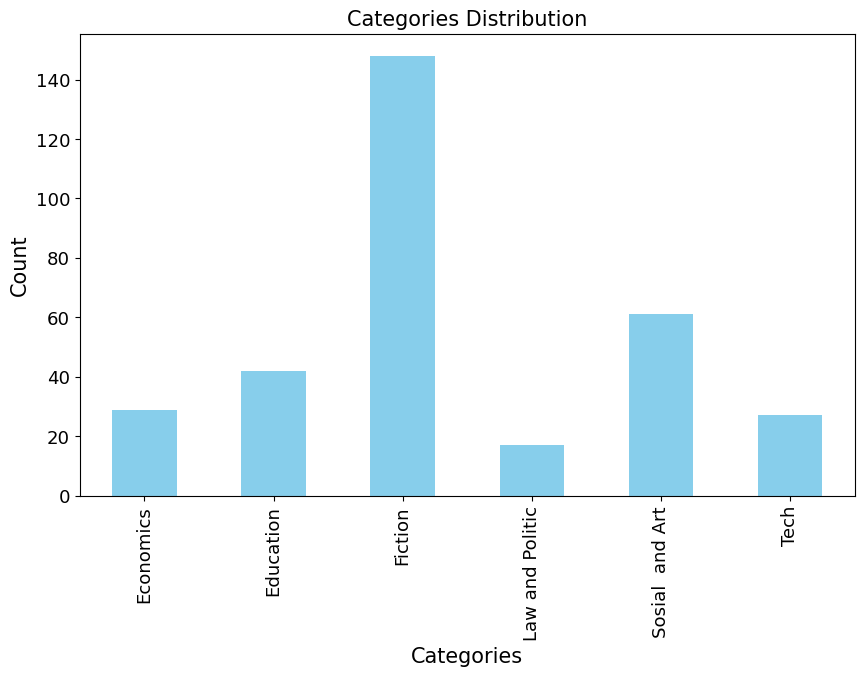

In [6]:
df2 = dataset.groupby(['Categories'])['Description'].count()
# create the plot
df2.plot(kind='bar', x='Categories', y='count', figsize=(10,6), color="skyblue", fontsize=13)

# set the x-label, y-label, and title
plt.xlabel('Categories', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Categories Distribution', fontsize=15)

In [7]:
label[0:10]

0    Education
1      Fiction
2    Education
3    Economics
4    Education
5    Economics
6      Fiction
7    Education
8    Education
9    Economics
Name: Categories, dtype: object

In [8]:
feature[0:10]

0    Siapa tidak kenal Sisca Soewitomo? Pakar kulin...
1    Ini kisah cinta yang biasa. Tentang tiga orang...
2    Riyas Irmadona, penulis buku ini adalah seoran...
3    Dalam era globalisasi, persaingan usaha sangat...
4    "Pasta adalah makanan olahan yang banyak digu-...
5    "Menjadi Salesman mungkin bukan merupakan pili...
6    Yuna jatuh cinta pada pandangan pertama dengan...
7    Buku ALL IN ONE TOEFL GRAMMAR dirancang secara...
8    Ulangan harian menjadi salah satu instrumen un...
9              Economic development in South Sumatera.
Name: Description, dtype: object

### Normalisasi Data
Silakan isi bagian ini dengan script untuk keperluan normalisasi data teks yang akan digunakan untuk pengembangan model klasifikasi teks.
Untuk setiap strategi normalisasi yang akan digunakan sebaiknya dibuat fungsi tersendiri dan dipanggil dalam satu fungsi normalisasi. Jangan lupa pada bagian ini ditampilkan contoh hasil normalisasi datanya.

In [9]:



character = ['z','y','x','w','v','u','t','s','r','q','p','o','n','m','l','k','j','i','h','g','f','e','d',',',';',':','-','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@']



def repeatcharNormalize(text):
  for i in range(len(character)):
    charac_long = 5
    while charac_long>=2:
      char=character[i]*charac_long
      text=text.replace(char,character[i])
      charac_long-=1
      return text



def spellNormalize(text):
    spellCheck = []
    for i in text:
        if i not in character:
            j = sc.correction(i)
            spellCheck.append(j)
        else:
            spellCheck.append(i)
    return spellCheck



def tokenize_text(text):
  tokens=nltk.word_tokenize(text)
  tokens=[token.strip() for token in tokens]
  return tokens




def expand_contractions(text, contraction_mapping):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) if contraction_mapping.get(match) else contraction_mapping.get(match.lower())
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def stemmer_text(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  text = stemmer.stem(text)
  return text



In [10]:
def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text



def remove_stopwords(text):
    tokens = tokenize_text(text)
    factory = StopWordRemoverFactory()
    stopword_list = factory.get_stop_words()
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def normalize_corpus(corpus, tokenize=False):
    normalized_corpus = []
    for text in corpus:
        text = expand_contractions(text, CONTRACTION_MAP)
        text = stemmer_text(text)
        text = remove_special_characters(text)
        text = repeatcharNormalize(text)
        text = remove_stopwords(text)
        if tokenize:
            text = tokenize_text(text)
            text = spellNormalize(text)
        normalized_corpus.append(text)
    return normalized_corpus


In [11]:
# training dataset
def prepare_datasets(corpus, labels, test_data_proportion=0.3):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels, test_size=test_data_proportion, random_state=42)
    return train_X, test_X, train_Y, test_Y

train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(feature, label, test_data_proportion=0.3)

In [12]:
# Mengganti nilai-nilai NaN dengan string kosong
train_corpus.fillna('', inplace=True)

# Memanggil fungsi normalize_corpus setelah menangani nilai-nilai yang kosong
norm_train_corpus = normalize_corpus(train_corpus)

In [13]:
norm_train_corpus[0:10]

['puji syukur panjat hadir allah swt atas ken teliti bidang hukum pusat teliti badan ahli dewan wakil rakyat republik indonesia dpr ri selesai tulis ilmiah susun bentuk buku sambut baik terbit buku lindung penting nasional dagang internasional bagai salah satu karya ilmiah hasil teliti bidang hukum pusat teliti badan ahli dpr ri susun buku dasar hasil teliti tim hukum pusat teliti badan ahli dpr ri laku tahun 2020 teliti dilatarbelakangi makin tingkat dagang internasional bawa dampak positif dampak negatif penting nasional indonesia dampak negatif sebut singkir usaha mikro kecil tengah umkm pasar marak edar barang impor bahaya tuduh curang negara mitra langgar hak kaya intelektual hki lindung penting nasional dampak negatif dagang internasional sangat butuh lindung sebut makin rasa penting era pandemi coronavirues disease 2019 covid19 akibat jadi tingkat dagang cara digital minim lindung empat aspek kaji buku aspek pertama kait hki gambar tulis e epelindungan hak kaya intelektual hki p

In [14]:
# Mengganti nilai-nilai NaN dengan string kosong
test_corpus.fillna('', inplace=True)

# Memanggil fungsi normalize_corpus setelah menangani nilai-nilai yang kosong
norm_test_corpus = normalize_corpus(test_corpus)

In [15]:
test_corpus.fillna('', inplace=True)

norm_test_corpus[0:10]



['kisah unik gaul manusia antarkelas sosial bagai karakter tak kalah tarik nick datang baru new york percaya orang simpan rahasia daisy meski mulut pedas taksir banyak laki balik selalu usaha rupa tutup sakit hati khianat suami tom suami daisy sekaligus teman kuliah nick lelaki didik tinggi kaya perangai kasar suka selingkuh tak suka selingkuh jordan perempuan muda cantik sinis pacar nick nick tahu selingkuh laku daisy tom pasang masingmasing terbit terbit serambi ilmu semesta serambi group',
 'james herriot baru lulus bagai dokter hewan tiba desa kecil darrowby yorkshire tak punya bayang sedikit hidup jalan teman baru jumpa bagai tualang tunggu buku cerita tahun pertama james herriot bagai dokter hewan desa darrowby indah hidup hari sama siegfried farnon eksentrik tristan farnon selalu sial ternak binatang andal bantu gaya cerita khas buat cinta seluruh dunia james herriot tutur cerita penuh tawa suka cita manusia binatang alam desa indah e edia cerita da',
 'gawat thor hilang benda p

### Ekstraksi Fitur
Silakan isi bagian ini dengan script untuk keperluan ekstraksi fitur data teks yang akan digunakan untuk pengembangan model klasifikasi teks.
Untuk setiap strategi ekstraksi fitur yang akan digunakan sebaiknya dibuat fungsi tersendiri dan dipanggil dalam satu fungsi ekstraksi fitur. Jangan lupa pada bagian ini ditampilkan contoh hasil ekstraksi fitur terhadap datanya.

In [16]:
# Fungsi untuk mengekstraksi feature menggunakan TF-IDF Model
def tfidf_transformer(bow_matrix):
    transformer = TfidfTransformer(norm='l2', smooth_idf=True, use_idf=True)
    tfidf_matrix = transformer.fit_transform(bow_matrix)
    return transformer, tfidf_matrix

def tfidf_extractor(corpus, ngram_range=(1,1)):
    vectorizer = TfidfVectorizer(min_df=1, norm='l2', smooth_idf=True, use_idf=True, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features





In [17]:
 #mengunakan model TF-IDF untuk mengekstraksi feature
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(norm_train_corpus)

# Menggunakan model TF-IDF yang sama untuk mengekstraksi feature dari test data
tfidf_test_features = tfidf_vectorizer.transform(norm_test_corpus)

In [18]:
train_features=tfidf_train_features
train_labels=train_labels
test_features=tfidf_test_features
test_labels=test_labels

In [19]:
df_train = pd.DataFrame()
df_train['train_feature'] = norm_train_corpus
df_train['train_labels'] = train_labels

df_test = pd.DataFrame()
df_test['test_feature'] = norm_test_corpus
df_test['test_labels'] = test_labels

In [20]:
df_train.fillna('', inplace=True)

df_train.head()




,train_feature,train_labels
0,puji syukur panjat hadir allah swt atas ken te...,Education
1,buku fenomenal a brief history of time stephen...,Fiction
2,e edi arah sana e e si kucing lambai cakar kan...,Education
3,aku tahu sekarang lebih banyak luka hati bapak...,
4,aku jadi tenang cinta banyak khawatir,Education


In [21]:
df_test.fillna('', inplace=True)

df_test.head()



,test_feature,test_labels
0,kisah unik gaul manusia antarkelas sosial baga...,
1,james herriot baru lulus bagai dokter hewan ti...,
2,gawat thor hilang benda paling harga milik apa...,
3,economic development in south sumatera,Economics
4,eun ha won benar cinderella sungguh tak sangka...,


### Model Training
Silakan isi bagian ini dengan script untuk keperluan training model klasifikasi teks. Jangan lupa untuk menjabarkan rancangan pemodelan algoritme yang akan diterapkan dan kombinasi parameter yang akan digunakan dengan benar dan lengkap.

In [22]:
#SGDC Classifier

pipeline_SGDC = Pipeline([
    ('feature_selection', SelectFromModel(LinearSVC())),
    ('classification', SGDClassifier())
])


pipeline_LinearSVC = Pipeline([
    ('feature_selection', SelectFromModel(LinearSVC())),
    ('classification', LinearSVC())
])


pipeline_NB = Pipeline([
    ('feature_selection', SelectFromModel(LinearSVC())),
    ('classification', MultinomialNB())
])

In [27]:
# Parameter yang akan
parameters_SGDC = {
      # Example parameter for TfidfVectorizer
    'feature_selection__estimator__C': [0.1, 1, 10],  # Example parameter for LinearSVC in SelectFromModel
    'feature_selection__threshold': ['mean', 'median', '1.5*mean'],  # Example parameter for SelectFromModel
    'classification__loss' : ['hinge','perceptron'],  # Example parameter for SGDClassifier
    'classification__alpha': [0.0001, 0.001, 0.01],  # Example parameter for SGDClassifier
    'classification__penalty': ['l1', 'l2', 'elasticnet'],  # Example parameter for SGDClassifier
   
    'classification__max_iter' : [50,100],# Example parameter for SGDClassifier
    'classification__verbose' : [0,1,2,3,4,5,6,7,8,9,10],
    'classification__epsilon' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

}

parameters_LinearSVC = {
    'feature_selection__estimator__C': [0.1, 1, 10],  # Example parameter for LinearSVC in SelectFromModel
    'feature_selection__threshold': ['mean', 'median', '1.5*mean'],  # Example parameter for SelectFromModel
    'classification__C': [0.1, 1, 10],  # Example parameter for LinearSVC
    'classification__loss': ['hinge', 'squared_hinge'],  # Example parameter for LinearSVC

    'classification__verbose': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Example parameter for LinearSVC
    'classification__penalty': ['l1', 'l2'],  # Example parameter for LinearSVC
    'classification__max_iter': [50, 100, 1000],  # Example parameter for LinearSVC
    'classification__tol': [0.0001, 0.001, 0.01],  # Example parameter for LinearSVC
}

parameters_NB = {
    'feature_selection__estimator__C': [0.1, 1, 10],  # Example parameter for LinearSVC in SelectFromModel
    'feature_selection__threshold': ['mean', 'median', '1.5*mean'],  # Example parameter for SelectFromModel
    'classification__alpha': [0.0001, 0.001, 0.01],  # Example parameter for MultinomialNB
    'classification__fit_prior': [True, False],  # Example parameter for MultinomialNB

}

INTERMESO : PENGGUNAAN GridSearchCV dan Hyperparameter di Neural Network TensorFlow

In [24]:
# from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# # Define the model architecture
# def create_model(hidden_units=32, activation='relu'):
#     model = Sequential()
#     model.add(Dense(hidden_units, activation=activation, input_shape=(input_dim,)))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Create the model
# model = KerasClassifier(build_fn=create_model)

# # Define the hyperparameters to search
# param_grid = {
#     'hidden_units': [16, 32, 64],
#     'activation': ['relu', 'sigmoid']
# }

# # Create the GridSearchCV object
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# # Fit the GridSearchCV object to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# # Print the best parameters and score
# print("Best Parameters: ", best_params)
# print("Best Score: ", best_score)


In [28]:
# Inisialisasi objek GridSearchCV
grid_search_SGDC = GridSearchCV(pipeline_SGDC, parameters_SGDC, n_jobs=-1)

grid_search_LinearSVC = GridSearchCV(pipeline_LinearSVC, parameters_LinearSVC, n_jobs=-1)

grid_search_NB = GridSearchCV(pipeline_NB, parameters_NB, n_jobs=-1)

In [29]:

# Fit the model using the list of strings
grid_search_SGDC.fit(train_features, train_labels)



-- Epoch 1
Norm: 53.59, NNZs: 655, Bias: -1.187890, T: 226, Avg. loss: 0.233276
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 55.57, NNZs: 653, Bias: -1.177993, T: 452, Avg. loss: 0.020262
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 55.57, NNZs: 611, Bias: -1.177993, T: 678, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 55.82, NNZs: 560, Bias: -1.232908, T: 904, Avg. loss: 0.000054
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 55.82, NNZs: 512, Bias: -1.232908, T: 1130, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 56.24, NNZs: 473, Bias: -1.232041, T: 1356, Avg. loss: 0.000716
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 56.24, NNZs: 430, Bias: -1.232041, T: 1582, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 56.24, NNZs: 394, Bias: -1.232041, T: 1808, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Convergence after 8 epochs took 0.00 seconds
-- Epoch 1
Norm: 65.46, NNZs: 1

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished


GridSearchCV(estimator=Pipeline(steps=[('feature_selection',
                                        SelectFromModel(estimator=LinearSVC())),
                                       ('classification', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'classification__alpha': [0.0001, 0.001, 0.01],
                         'classification__epsilon': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                     0.6, 0.7, 0.8, 0.9, 1.0],
                         'classification__loss': ['hinge', 'perceptron'],
                         'classification__max_iter': [50, 100],
                         'classification__penalty': ['l1', 'l2', 'elasticnet'],
                         'classification__verbose': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                     9, 10],
                         'feature_selection__estimator__C': [0.1, 1, 10],
                         'feature_selection__threshold': ['mean', 'median',
                                                          '1.5*mean']})

In [30]:
print("Best Score: ", grid_search_SGDC.best_score_)
print("Best Parameters: ", grid_search_SGDC.best_params_)
print("Best Estimator: ", grid_search_SGDC.best_estimator_)


Best Score:  0.7123671497584542
Best Parameters:  {'classification__alpha': 0.0001, 'classification__epsilon': 0.2, 'classification__loss': 'hinge', 'classification__max_iter': 50, 'classification__penalty': 'l1', 'classification__verbose': 4, 'feature_selection__estimator__C': 1, 'feature_selection__threshold': 'median'}
Best Estimator:  Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1), threshold='median')),
                ('classification',
                 SGDClassifier(epsilon=0.2, max_iter=50, penalty='l1',
                               verbose=4))])


In [31]:
grid_search_LinearSVC.fit(train_features, train_labels)



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
26730 fits failed out of a total of 53460.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13365 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_esti

GridSearchCV(estimator=Pipeline(steps=[('feature_selection',
                                        SelectFromModel(estimator=LinearSVC())),
                                       ('classification', LinearSVC())]),
             n_jobs=-1,
             param_grid={'classification__C': [0.1, 1, 10],
                         'classification__loss': ['hinge', 'squared_hinge'],
                         'classification__max_iter': [50, 100, 1000],
                         'classification__penalty': ['l1', 'l2'],
                         'classification__tol': [0.0001, 0.001, 0.01],
                         'classification__verbose': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                     9, 10],
                         'feature_selection__estimator__C': [0.1, 1, 10],
                         'feature_selection__threshold': ['mean', 'median',
                                                          '1.5*mean']})

In [32]:
print("Best Score: ", grid_search_LinearSVC.best_score_)
print("Best Parameters: ", grid_search_LinearSVC.best_params_)
print("Best Estimator: ", grid_search_LinearSVC.best_estimator_)

Best Score:  0.6593236714975845
Best Parameters:  {'classification__C': 10, 'classification__loss': 'hinge', 'classification__max_iter': 50, 'classification__penalty': 'l2', 'classification__tol': 0.0001, 'classification__verbose': 0, 'feature_selection__estimator__C': 10, 'feature_selection__threshold': 'mean'}
Best Estimator:  Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=10), threshold='mean')),
                ('classification', LinearSVC(C=10, loss='hinge', max_iter=50))])


In [33]:
grid_search_NB.fit(train_features, train_labels)



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('feature_selection',
                                        SelectFromModel(estimator=LinearSVC())),
                                       ('classification', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'classification__alpha': [0.0001, 0.001, 0.01],
                         'classification__fit_prior': [True, False],
                         'feature_selection__estimator__C': [0.1, 1, 10],
                         'feature_selection__threshold': ['mean', 'median',
                                                          '1.5*mean']})

In [34]:
print("Best Score: ", grid_search_NB.best_score_)
print("Best Parameters: ", grid_search_NB.best_params_)
print("Best Estimator: ", grid_search_NB.best_estimator_)

Best Score:  0.7213526570048309
Best Parameters:  {'classification__alpha': 0.01, 'classification__fit_prior': False, 'feature_selection__estimator__C': 0.1, 'feature_selection__threshold': 'median'}
Best Estimator:  Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=0.1),
                                 threshold='median')),
                ('classification', MultinomialNB(alpha=0.01, fit_prior=False))])


### Model Evaluation
Silakan isi bagian ini dengan script untuk keperluan evaluasi model klasifikasi teks. Jangan lupa untuk menjabarkan rancangan proses evaluasi model, metrik, dan visualisasi confusion matrix yang akan digunakan dengan benar dan lengkap

In [35]:
def get_metrics(true_labels, predicted_labels):
    print('Accuracy: ', np.round(metrics.accuracy_score(true_labels, predicted_labels), 2))
    print('Precision: ', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'), 2))
    print('Recall: ', np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 2))
    print('F1 Score: ', np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 2))

In [36]:
def get_confusion_matrix(true_labels, predicted_labels):
    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
    return cm

In [38]:
# Prediksi menggunakan model Model



predictions_SGDC = grid_search_SGDC.best_estimator_.predict(test_features)

predictions_LinearSVC = grid_search_LinearSVC.best_estimator_.predict(test_features)

predictions_NB = grid_search_NB.best_estimator_.predict(test_features)

SGDC Metrics:
Accuracy:  0.66
Precision:  0.68
Recall:  0.66
F1 Score:  0.65
Classification Report:
                 precision    recall  f1-score   support

      Economics       0.56      0.50      0.53        10
      Education       0.88      0.47      0.61        15
        Fiction       0.82      0.93      0.87        43
Law and Politic       0.18      0.33      0.24         6
Sosial  and Art       0.42      0.28      0.33        18
           Tech       0.67      1.00      0.80         6

       accuracy                           0.66        98
      macro avg       0.59      0.58      0.56        98
   weighted avg       0.68      0.66      0.65        98

Confusion Matrix:
[[ 5  0  0  2  2  1]
 [ 1  7  3  1  2  1]
 [ 1  0 40  0  2  0]
 [ 1  1  1  2  1  0]
 [ 1  0  5  6  5  1]
 [ 0  0  0  0  0  6]]


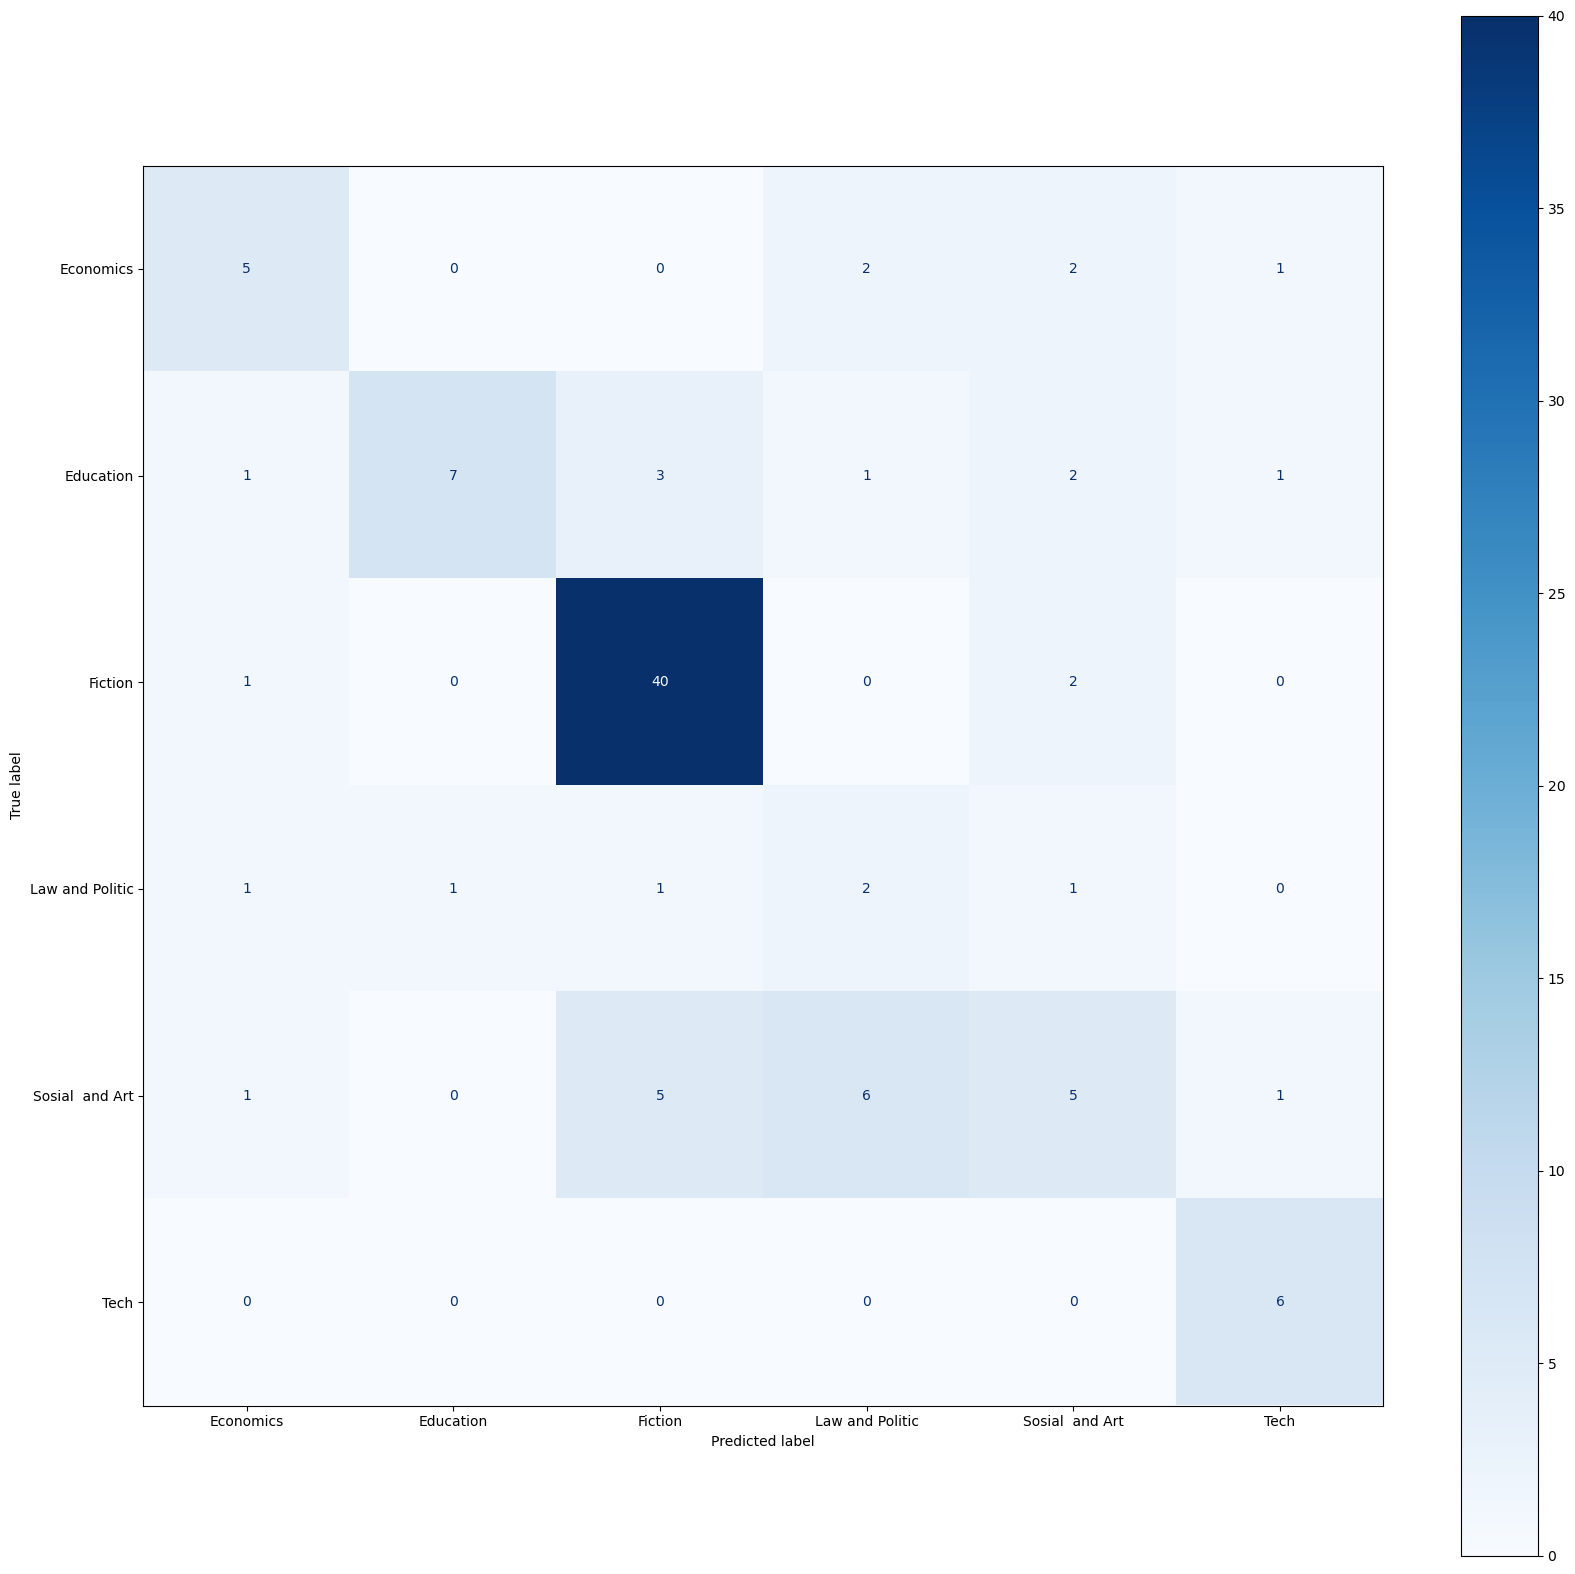

In [39]:


#Evaluasi Masing-Masing mode

print("SGDC Metrics:")

get_metrics(true_labels=test_labels, predicted_labels=predictions_SGDC)

print("Classification Report:")
print(metrics.classification_report(test_labels, predictions_SGDC))
print("Confusion Matrix:")
print(get_confusion_matrix(test_labels, predictions_SGDC))



disp = ConfusionMatrixDisplay(confusion_matrix=get_confusion_matrix(test_labels, predictions_SGDC), display_labels=grid_search_SGDC.best_estimator_.classes_)

fig, ax = plt.subplots(figsize=(20, 20))


disp.plot(ax=ax, cmap=plt.cm.Blues)











LinearSVC Metrics:
Accuracy:  0.67
Precision:  0.65
Recall:  0.67
F1 Score:  0.65
Classification Report:
                 precision    recall  f1-score   support

      Economics       0.46      0.60      0.52        10
      Education       0.67      0.40      0.50        15
        Fiction       0.81      0.98      0.88        43
Law and Politic       0.50      0.33      0.40         6
Sosial  and Art       0.43      0.33      0.38        18
           Tech       0.67      0.67      0.67         6

       accuracy                           0.67        98
      macro avg       0.59      0.55      0.56        98
   weighted avg       0.65      0.67      0.65        98

Confusion Matrix:
[[ 6  0  1  0  3  0]
 [ 2  6  3  0  3  1]
 [ 0  0 42  0  1  0]
 [ 0  3  0  2  0  1]
 [ 5  0  5  2  6  0]
 [ 0  0  1  0  1  4]]


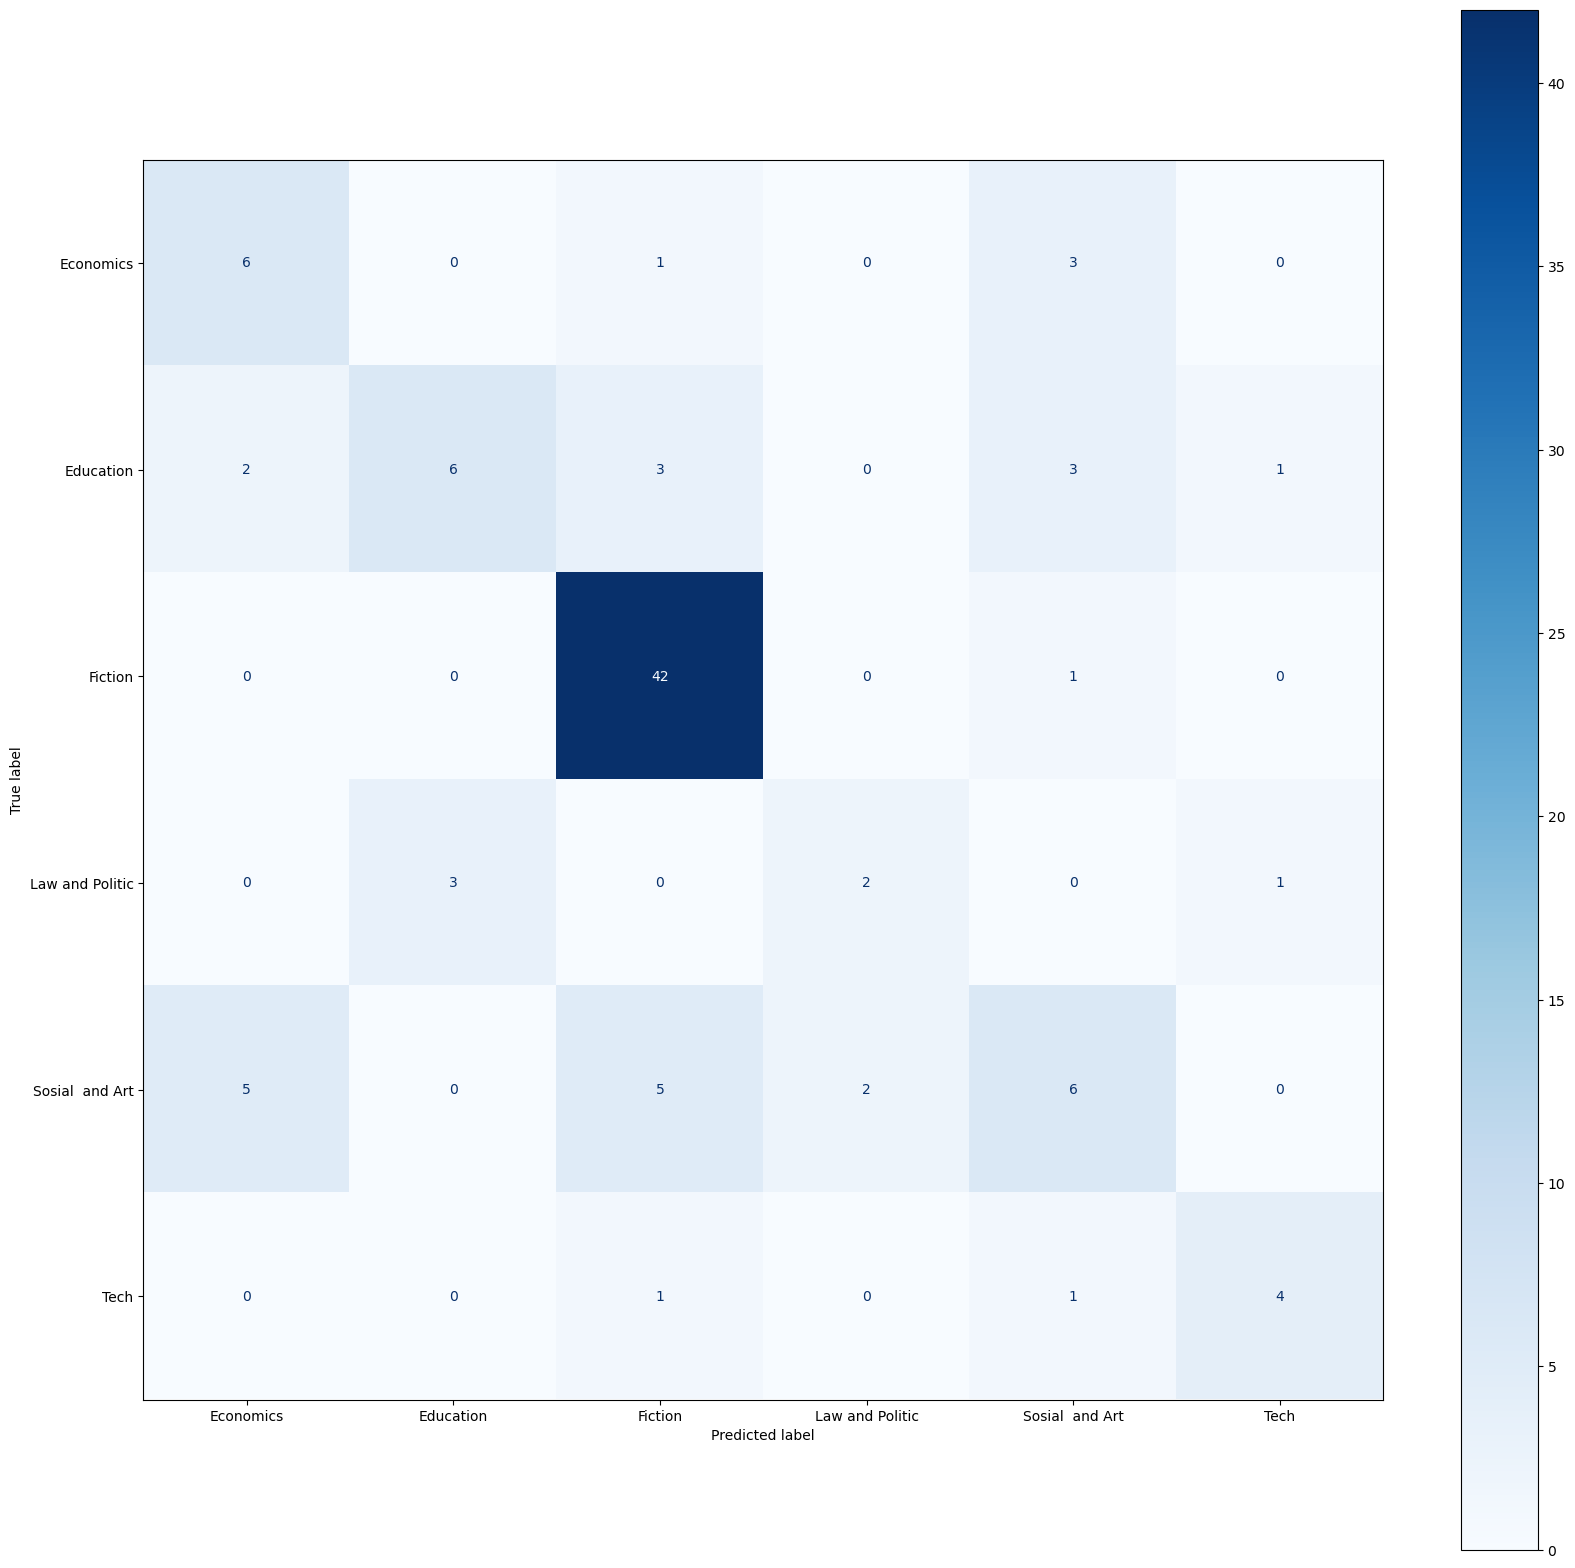

In [40]:
print("LinearSVC Metrics:")

get_metrics(true_labels=test_labels, predicted_labels=predictions_LinearSVC)

print("Classification Report:")
print(metrics.classification_report(test_labels, predictions_LinearSVC))
print("Confusion Matrix:")
print(get_confusion_matrix(test_labels, predictions_LinearSVC))


disp = ConfusionMatrixDisplay(confusion_matrix=get_confusion_matrix(test_labels, predictions_LinearSVC), display_labels=grid_search_SGDC.best_estimator_.classes_)

fig, ax = plt.subplots(figsize=(20, 20))


disp.plot(ax=ax, cmap=plt.cm.Blues)

NB Metrics:
Accuracy:  0.59
Precision:  0.62
Recall:  0.59
F1 Score:  0.59
Classification Report:
                 precision    recall  f1-score   support

      Economics       0.25      0.40      0.31        10
      Education       0.45      0.33      0.38        15
        Fiction       0.90      0.81      0.85        43
Law and Politic       0.50      0.50      0.50         6
Sosial  and Art       0.36      0.28      0.31        18
           Tech       0.50      1.00      0.67         6

       accuracy                           0.59        98
      macro avg       0.49      0.55      0.50        98
   weighted avg       0.62      0.59      0.59        98

Confusion Matrix:
[[ 4  0  0  2  2  2]
 [ 3  5  1  0  3  3]
 [ 2  2 35  0  4  0]
 [ 1  2  0  3  0  0]
 [ 6  2  3  1  5  1]
 [ 0  0  0  0  0  6]]


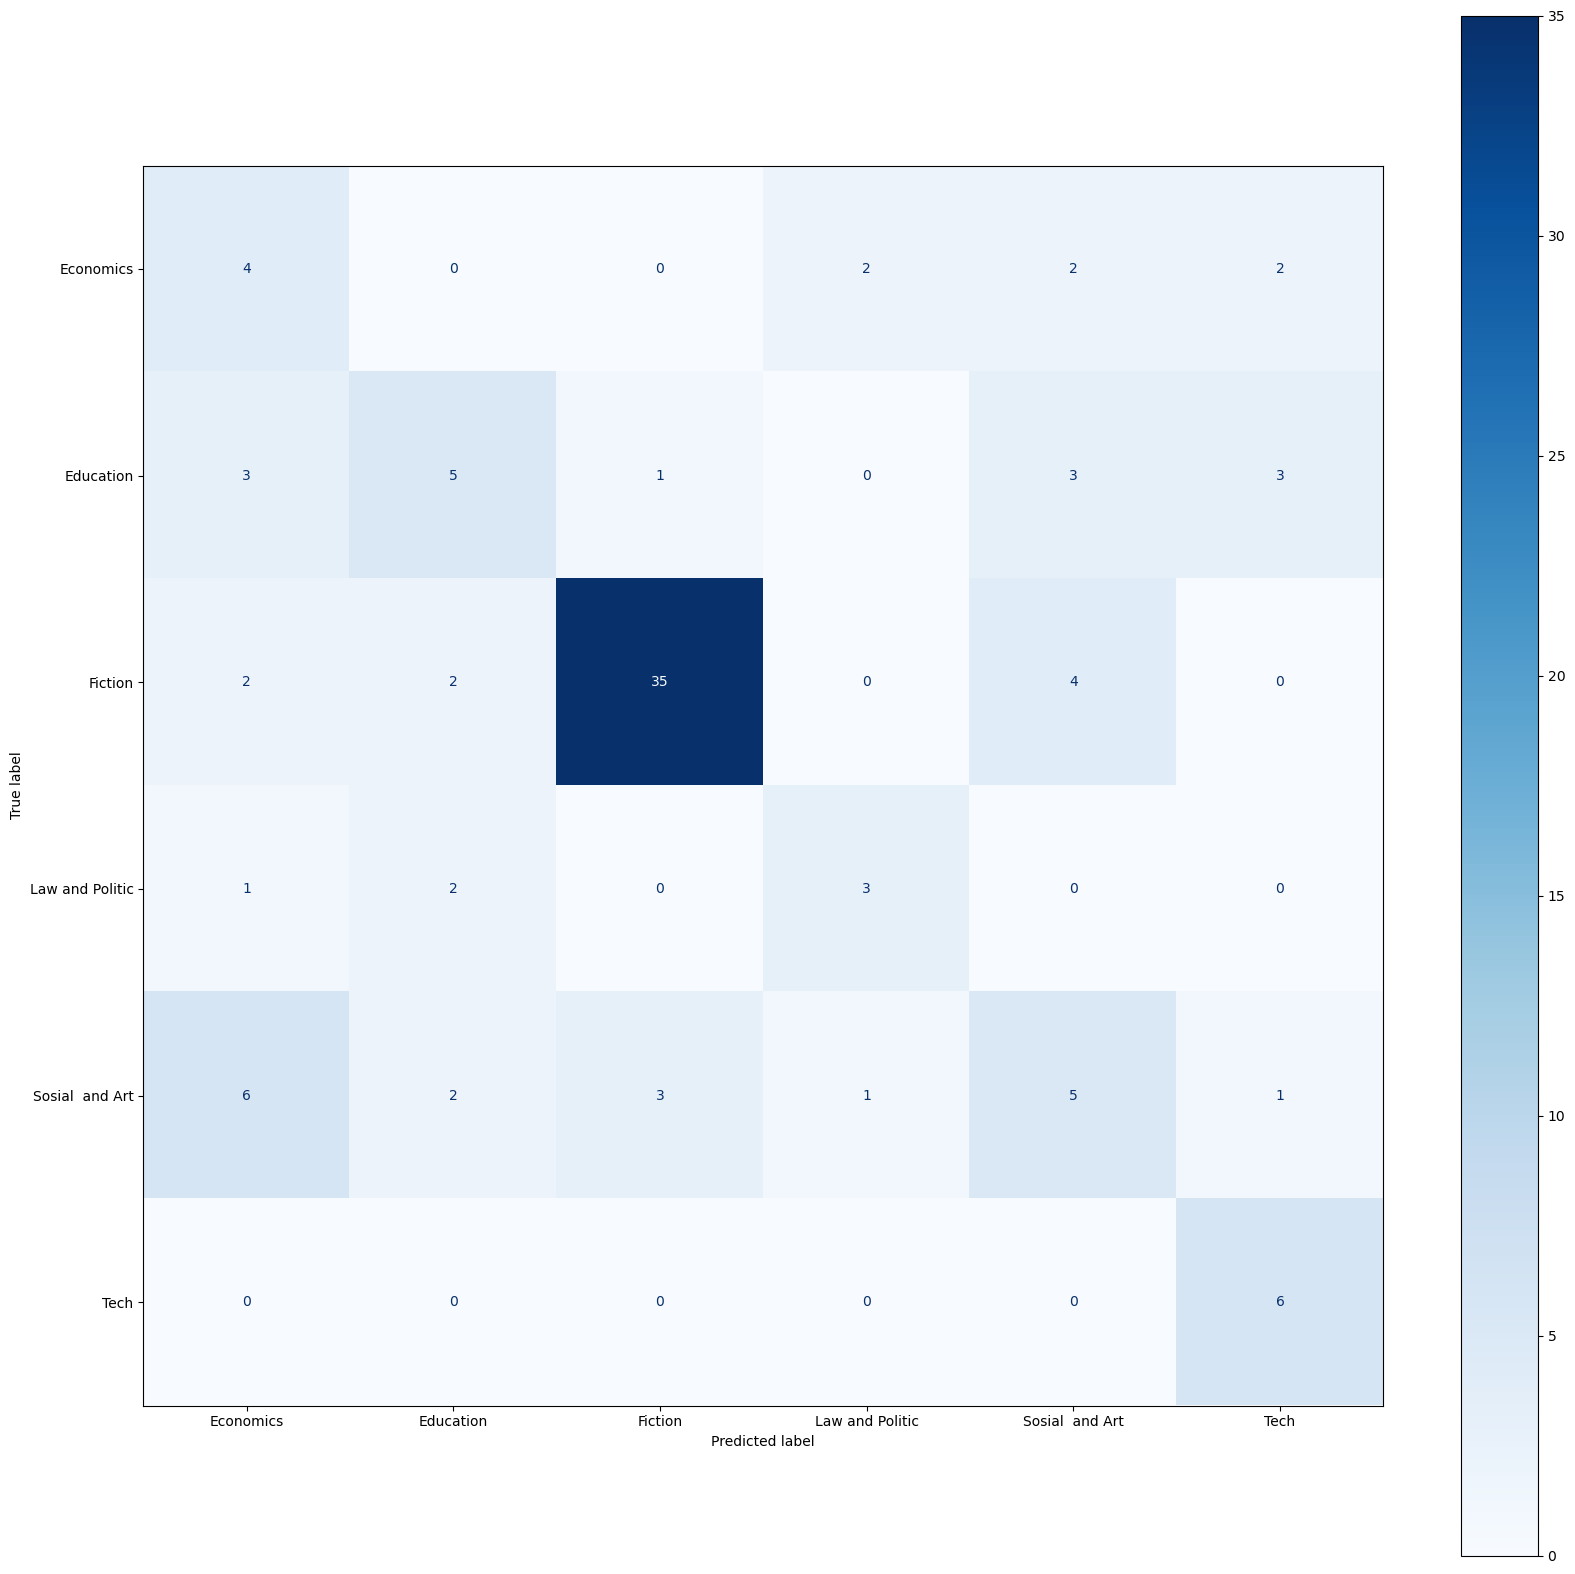

In [41]:
print("NB Metrics:")

get_metrics(true_labels=test_labels, predicted_labels=predictions_NB)

print("Classification Report:")
print(metrics.classification_report(test_labels, predictions_NB))
print("Confusion Matrix:")
print(get_confusion_matrix(test_labels, predictions_NB))


disp = ConfusionMatrixDisplay(confusion_matrix=get_confusion_matrix(test_labels, predictions_NB), display_labels=grid_search_SGDC.best_estimator_.classes_)

fig, ax = plt.subplots(figsize=(20, 20))

disp.plot(ax=ax, cmap=plt.cm.Blues)


### Model Testing
Silakan isi bagian ini dengan script untuk keperluan testing model terbaik yang telah dihasilkan dengan memberikan input berupa data teks yang sama sekali baru dan belum ada di dataset.

In [49]:

# Save the model

import joblib

joblib.dump(grid_search_SGDC.best_estimator_, 'model_SGDC.pkl')
joblib.dump(grid_search_LinearSVC.best_estimator_, 'model_LinearSVC.pkl')
joblib.dump(grid_search_NB.best_estimator_, 'model_NB.pkl')

# Load the model

model_SGDC = joblib.load('model_SGDC.pkl')
model_LinearSVC = joblib.load('model_LinearSVC.pkl')
model_NB = joblib.load('model_NB.pkl')



# Load the test data
test = test_features[5]




# Predict using the model

predictions_SGDC = model_SGDC.predict(test)
predictions_LinearSVC = model_LinearSVC.predict(test)
predictions_NB = model_NB.predict(test)


In [51]:

# Print the predicted value



print("SGDClassifier Prediction: ", predictions_SGDC)
print("LinearSVC Prediction: ", predictions_LinearSVC)
print("MultinomialNB Prediction: ", predictions_NB)

SGDClassifier Prediction:  ['Fiction']
LinearSVC Prediction:  ['Fiction']
MultinomialNB Prediction:  ['Fiction']
